In [22]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot

In [2]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep=" ")

First, a rerun of rfmix read in to make it 100 % comparable.

In [27]:
def length_to_windows_rf(length_df, pops, window_size=100000):
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind_rf(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [24]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_females_gen50/"
input_file = rfmix_path + "chrX.msp.tsv"
chrX = pd.read_csv(input_file, sep = "\t", header=1)
file = open(input_file, 'r')
line1 = file.readline()
file.close()

In [25]:
number_subpop_mapping = {}
for subpop in line1.strip().split("\t"):
    # Splitting to create lists containing two values - subpop and number.
    subpop_number = subpop.split(": ")[-1].split("=")
    number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
# North is 1, South is 0
north_south_mapping = {'Hamadryas, Ethiopia': 1, 'Papio, Senegal': 1, 'Kindae, Zambia': 0, 'Ursinus, Zambia': 0}

In [26]:
df_l = []
for hap in chrX.columns[6:]:
    df_l.append(create_paint_df_ind_rf(chrX, hap, number_subpop_mapping, north_south_mapping))
length_df_X_rf = pd.concat(df_l)

In [28]:
df_l = []
for ID in length_df_X_rf.individual.unique():
    ID_df = length_df_X_rf.loc[length_df_X_rf.individual == ID]
    window_ID_df = length_to_windows_rf(ID_df, sorted(length_df_X_rf["reference"].unique()))
    window_ID_df["PDGP_ID"] = ID
    #print(ID)
    df_l.append(window_ID_df)
window_df_rf = pd.concat(df_l)

In [44]:
window_df_rf["percent_north"] = ((window_df_rf["Hamadryas, Ethiopia"]+window_df_rf["Papio, Senegal"])/window_df_rf.iloc[:,1:5].sum(axis=1))
window_df_rf["norm_north"] = (((window_df_rf["Hamadryas, Ethiopia"]+window_df_rf["Papio, Senegal"])-window_df_rf.iloc[:,1:5].sum(axis=1)/2))
window_df_rf["start"] = window_df_rf.windows
window_df_rf["chrom"] = "chrX"

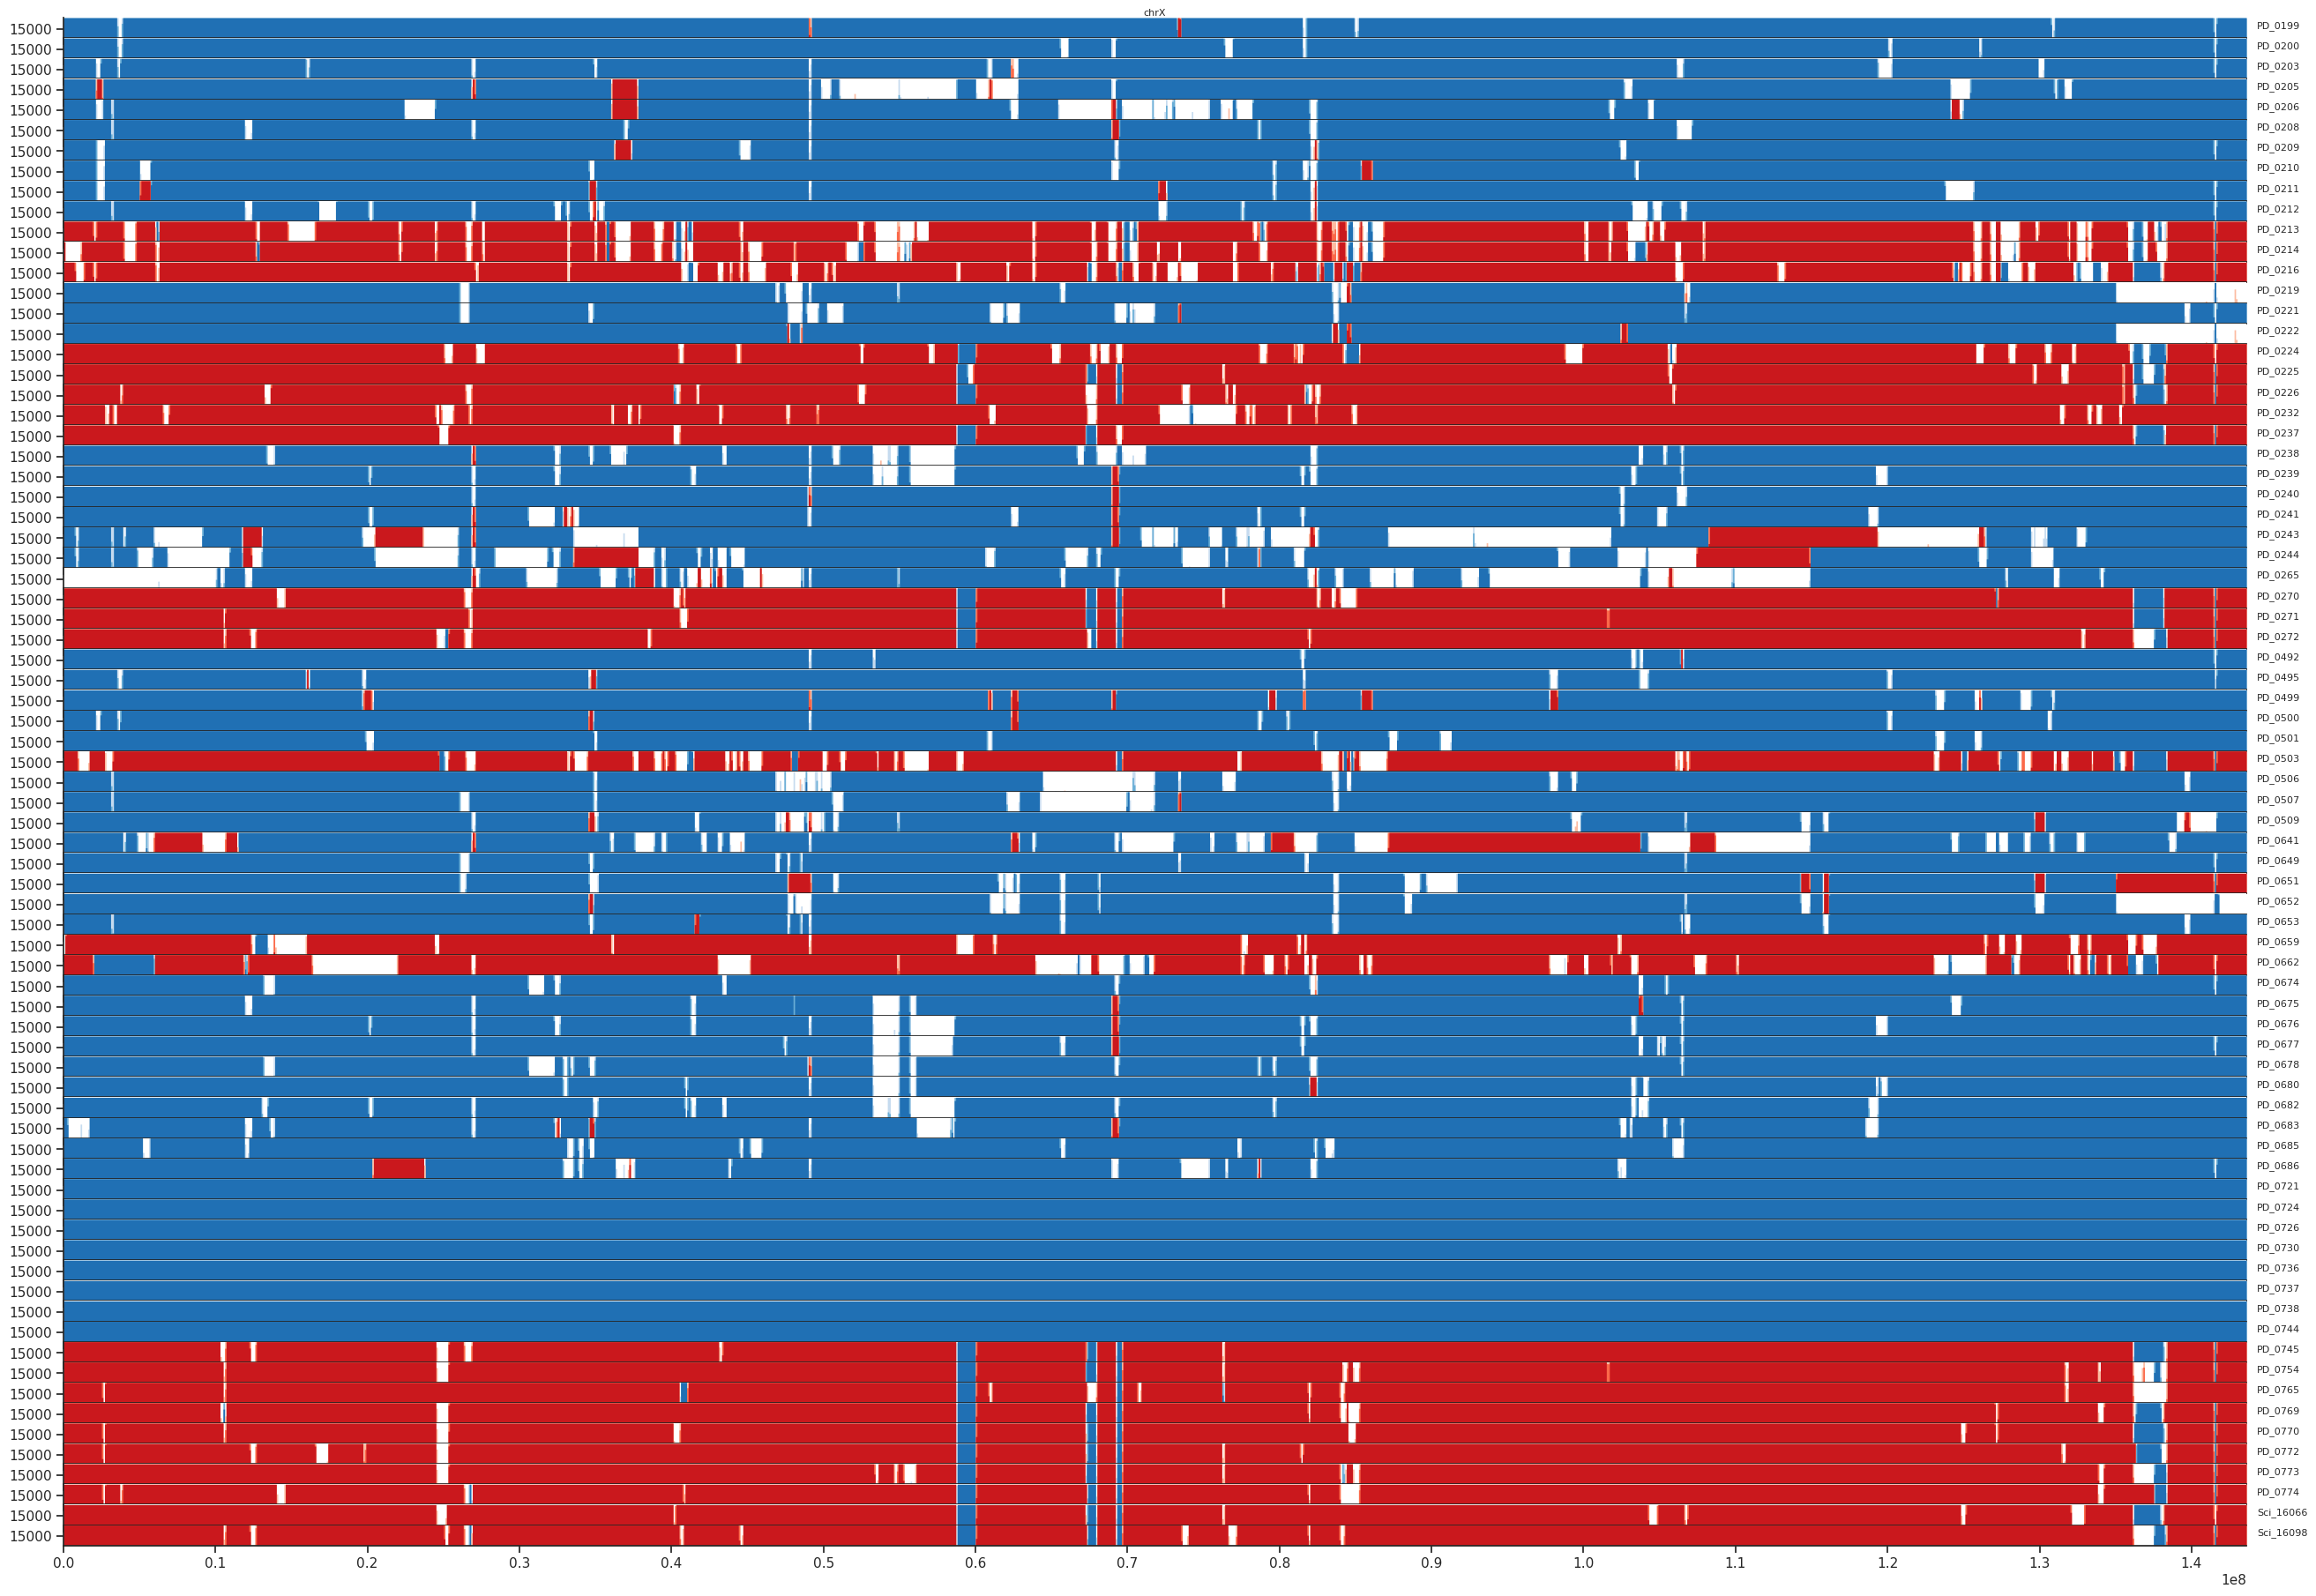

In [46]:
fig = horizonplot(window_df_rf, 'norm_north', width=2, col='chrom', row='PDGP_ID', size=0.3, aspect=100)

In [118]:
yellow_subset = window_df_rf.loc[window_df_rf.PDGP_ID.isin(meta_data_samples.loc[meta_data_samples.Origin == "Mikumi, Tanzania"].PGDP_ID)]

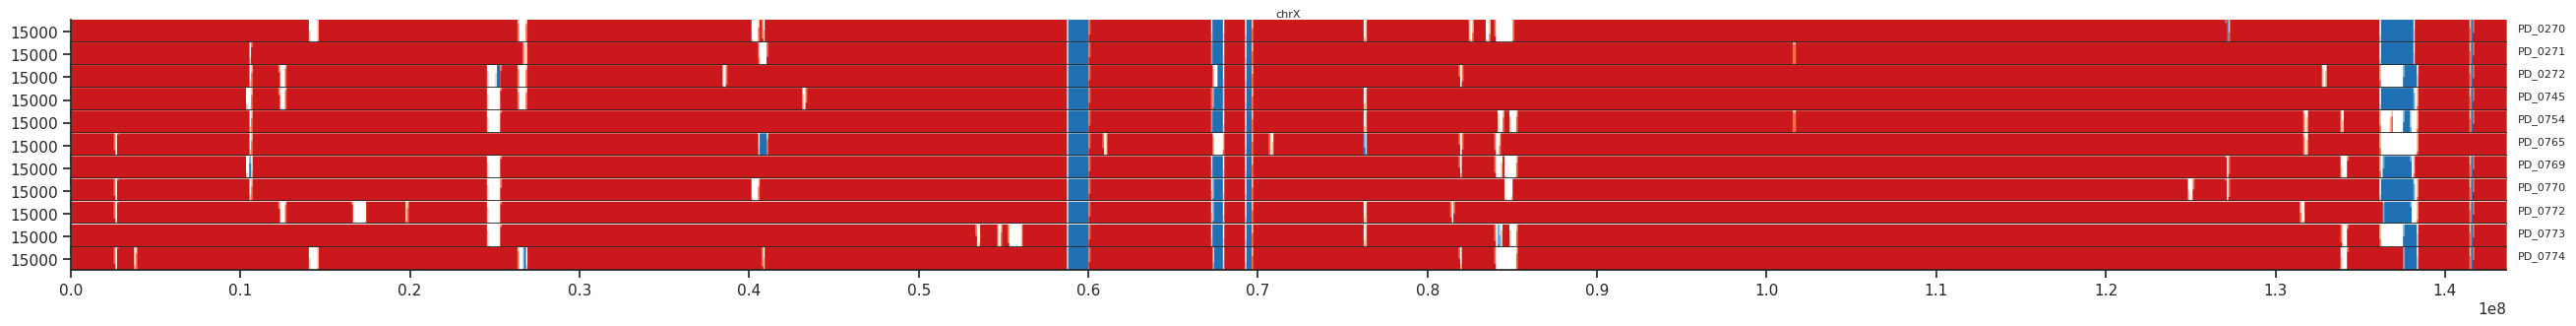

In [119]:
fig = horizonplot(yellow_subset, 'norm_north', width=2, col='chrom', row='PDGP_ID', size=0.3, aspect=100)

Onwards to mosaic

In [4]:
test_file = '../mosaic/results_dfs/localancMikumi_anc2_chr30_30_maf10_2anc_distant_simple.RData'

In [5]:
# %load https://gist.githubusercontent.com/kaspermunch/09bb5b006898c570a7071a2011501532/raw/6b48ffd20dc0e49b79202ec257c836f82bfa671b/
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import os, sys

def list_rdata(path):
    print(path)
    if not os.path.getsize(path):
        print('      (file is empty)')
        return
    names = list(robjects.r['load'](path))
    for name in names:
        print(f'      {name.ljust(25)}: {robjects.r[name].__class__.__name__}')

def read_rdata(path, name=None):    
    names = list(robjects.r['load'](path))
    if len(names) > 1 and name is None:
        sys.stderr.write('File contains multiple variables and no variable name specified: name=None')
        return None
    if name is None:
        name = names[0]
    r_df = robjects.r[name]
    with (robjects.default_converter + pandas2ri.converter).context():
        return robjects.conversion.get_conversion().rpy2py(r_df).byindex(0)[1]

## Example use:
# print the names and types of variables in data file
list_rdata(test_file)  

# reading a a file with a single variable
#read_rdata('file.Rdata')

# the name argument is required when reading a file containing multiple variables
localanc_data = read_rdata(test_file, name='localanc')

../mosaic/results_dfs/localancMikumi_anc2_chr30_30_maf10_2anc_distant_simple.RData
      localanc                 : ListVector
      final.flips              : ListVector
      g.loc                    : ListVector


In [6]:
len(localanc_data[0][0])

7622

In [7]:
7622/60

127.03333333333333

In [102]:
localanc_data[1][0]

array([0.98052174, 0.98616001, 0.98898529, ..., 0.10246853, 0.13663592,
       0.16878492])

In [13]:
recomb_map = pd.read_csv("/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_chrX.txt", sep=" ")

<Axes: >

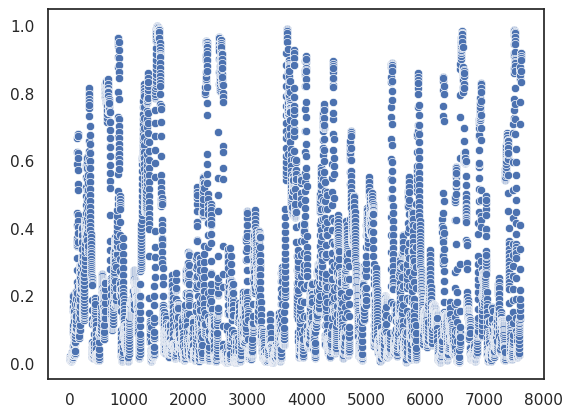

In [9]:
sns.scatterplot(y=localanc_data[0][0],x=range(len(localanc_data[0][0])))

Creating the corresponding start points for the mosaic intervals, using the length of the dataframe (for flexibility if I later change it).

In [60]:
step_size_cM = recomb_map["Genetic_Map(cM)"].max()/len(localanc_data[0][0])
current_break = 0
pos_list = []
for i in range(len(recomb_map)):
    if recomb_map["Genetic_Map(cM)"][i] > current_break:
        pos_list.append(recomb_map["position"][i])
        current_break += step_size_cM

In [62]:
len(pos_list)

7622

In [111]:
mikumi_IDs = meta_data_samples.loc[(meta_data_samples.Origin == "Mikumi, Tanzania")
                                         & (meta_data_samples.Sex == "F")].PGDP_ID.reset_index()

In [90]:
len(mikumi_IDs), len(localanc_data[0])

(13, 26)

In [74]:
test_horizon = pd.DataFrame({"major_anc": localanc_data[0][0]-0.5, "start": pos_list, "chrom": "chrX", "PDGP_ID": "test"})

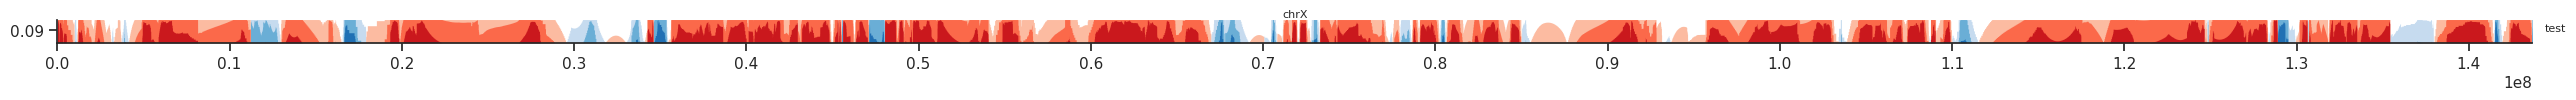

In [75]:
fig = horizonplot(test_horizon, 'major_anc', width=2, col='chrom', row='PDGP_ID', size=0.3, aspect=100)

In [116]:
df_l = []
for i in range(len(localanc_data[0])//2):
    mean_anc = (localanc_data[0][i]+localanc_data[0][i+1])/2
    df_sub = pd.DataFrame({"major_anc": mean_anc-0.5, "start": pos_list,
                        "chrom": "chrX", "PDGP_ID": mikumi_IDs.PGDP_ID[i]})
    df_l.append(df_sub)
major_anc_df = pd.concat(df_l)

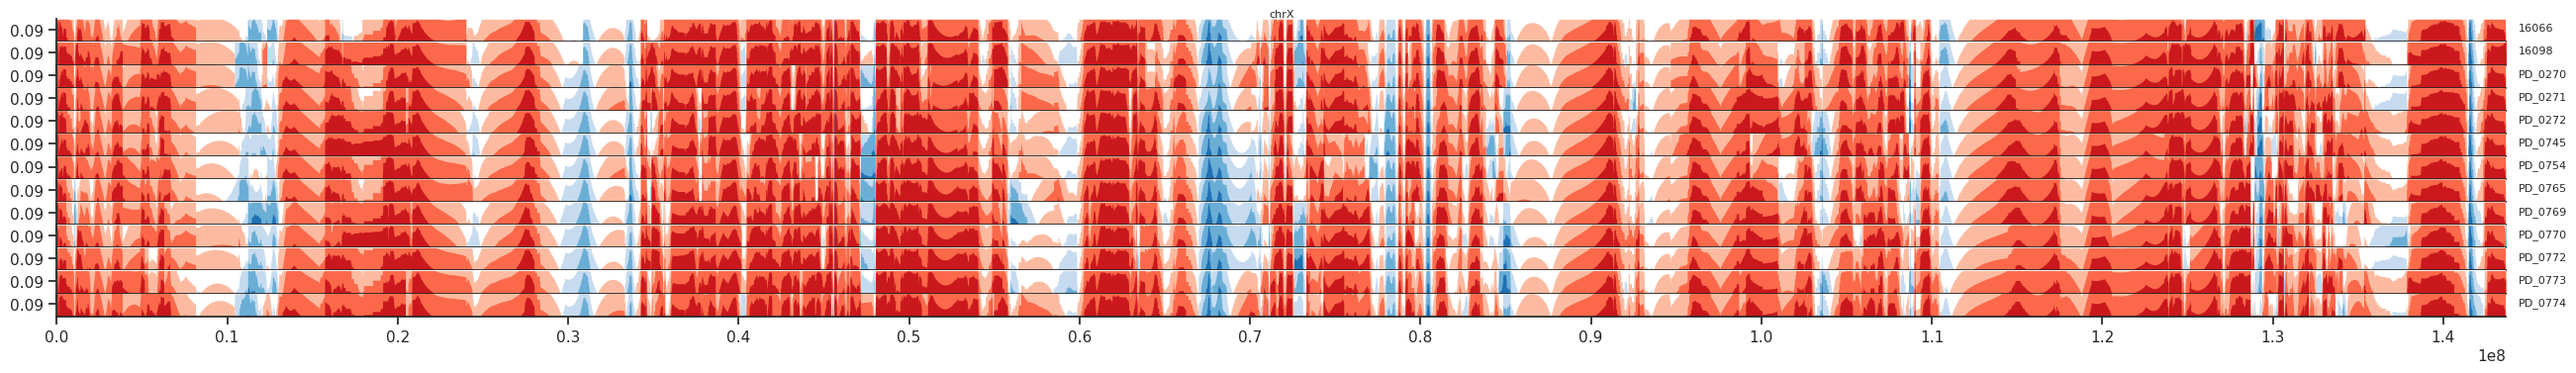

In [ ]:
fig = horizonplot(major_anc_df, 'major_anc', width=2, col='chrom', row='PDGP_ID', size=0.3, aspect=100)